# Phase 4: Z-Axis (B-scan Direction) Alignment

This notebook aligns volumes along the Z-axis (B-scan direction) using phase correlation on coronal planes.

## Approach:
After XY alignment, we apply phase correlation to YZ planes (coronal slices) to find any Z-axis offset.

## Workflow:
1. Load XY registration parameters
2. Apply XY translation to volume 1
3. Extract coronal slices from both volumes
4. Apply phase correlation in Z direction
5. Save complete 3D transformation (dx, dy, dz)

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal, ndimage
import sys

# Add src to path (handle both running from notebooks/ and from root)
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    sys.path.append(str(notebook_dir.parent / 'src'))
    data_dir = notebook_dir / 'data'
else:
    sys.path.append(str(notebook_dir / 'src'))
    data_dir = notebook_dir / 'notebooks' / 'data'

from oct_volumetric_viewer import OCTImageProcessor, OCTVolumeLoader

print("✓ Imports complete")

✓ Imports complete


## Step 1: Load XY Registration Results

In [2]:
# Load XY registration parameters
xy_params = np.load(data_dir / 'xy_registration_params.npy', allow_pickle=True).item()

print("✓ Loaded XY registration parameters:")
print(f"  Method: {xy_params['method']}")
print(f"  X offset: {xy_params['offset_x']} pixels")
print(f"  Z offset (from XY): {xy_params['offset_z']} pixels")
print(f"  Confidence: {xy_params['confidence']:.2f}")

offset_x_xy = xy_params['offset_x']
offset_z_xy = xy_params['offset_z']

✓ Loaded XY registration parameters:
  Method: phase_correlation
  X offset: -412 pixels
  Z offset (from XY): 5 pixels
  Confidence: 31.16


## Step 2: Load Full 3D Volumes

In [3]:
print("Loading full 3D OCT volumes...")
print("This may take 1-2 minutes...")

# Initialize loader with updated cropping
processor = OCTImageProcessor(sidebar_width=250, crop_top=100, crop_bottom=50)
loader = OCTVolumeLoader(processor)

# Find volume directories
oct_data_dir = Path('../oct_data')
bmp_dirs = []
for bmp_file in oct_data_dir.rglob('*.bmp'):
    vol_dir = bmp_file.parent
    if vol_dir not in bmp_dirs:
        bmp_dirs.append(vol_dir)

all_volume_dirs = sorted(bmp_dirs)
f001_vols = [v for v in all_volume_dirs if 'F001_IP' in str(v)]

if len(f001_vols) >= 2:
    print(f"\nUsing F001 data:")
    print(f"  Volume 0: {f001_vols[0].name}")
    print(f"  Volume 1: {f001_vols[1].name}")
    volume_dirs = f001_vols[:2]
else:
    print(f"\nWarning: Using first 2 available volumes")
    volume_dirs = all_volume_dirs[:2]

# Load volumes
print("\nLoading volume 0...")
volume_0 = loader.load_volume_from_directory(str(volume_dirs[0]))

print("Loading volume 1...")
volume_1 = loader.load_volume_from_directory(str(volume_dirs[1]))

print(f"\n✓ Loaded volumes:")
print(f"  Volume 0: {volume_0.shape} (height, width, depth)")
print(f"  Volume 1: {volume_1.shape}")

2025-11-03 14:59:34,255 - INFO - Found 360 BMP files
2025-11-03 14:59:34,362 - INFO - Loading scan 1/360


Loading full 3D OCT volumes...
This may take 1-2 minutes...

Using F001 data:
  Volume 0: F001_IP_20250604_175814_Retina_3D_L_6mm_1536x360_2
  Volume 1: F001_IP_20250604_180102_Retina_3D_L_6mm_1536x360_2

Loading volume 0...


2025-11-03 14:59:40,525 - INFO - Loading scan 51/360
2025-11-03 14:59:44,779 - INFO - Loading scan 101/360
2025-11-03 14:59:49,002 - INFO - Loading scan 151/360
2025-11-03 14:59:53,229 - INFO - Loading scan 201/360
2025-11-03 14:59:57,459 - INFO - Loading scan 251/360
2025-11-03 15:00:01,660 - INFO - Loading scan 301/360
2025-11-03 15:00:05,857 - INFO - Loading scan 351/360
2025-11-03 15:00:06,691 - INFO - Successfully loaded volume with shape (842, 1536, 360)
2025-11-03 15:00:06,697 - INFO - Found 360 BMP files
2025-11-03 15:00:06,769 - INFO - Loading scan 1/360


Loading volume 1...


2025-11-03 15:00:12,277 - INFO - Loading scan 51/360
2025-11-03 15:00:16,304 - INFO - Loading scan 101/360
2025-11-03 15:00:20,550 - INFO - Loading scan 151/360
2025-11-03 15:00:24,718 - INFO - Loading scan 201/360
2025-11-03 15:00:28,784 - INFO - Loading scan 251/360
2025-11-03 15:00:32,866 - INFO - Loading scan 301/360
2025-11-03 15:00:36,956 - INFO - Loading scan 351/360
2025-11-03 15:00:37,792 - INFO - Successfully loaded volume with shape (842, 1536, 360)



✓ Loaded volumes:
  Volume 0: (842, 1536, 360) (height, width, depth)
  Volume 1: (842, 1536, 360)


## Step 3: Apply XY Translation

In [4]:
# Apply XY translation from Phase 3
# shift order for 3D volume: (y, x, z)
# We only have x and z from XY registration, y will be determined later
volume_1_xy_aligned = ndimage.shift(
    volume_1,
    shift=(0, offset_x_xy, offset_z_xy),  # (dy=0 for now, dx, dz)
    order=1,
    mode='constant',
    cval=0
)

print(f"✓ Applied XY translation: (x={offset_x_xy}, z={offset_z_xy})")
print(f"  Volume 1 XY-aligned shape: {volume_1_xy_aligned.shape}")

✓ Applied XY translation: (x=-412, z=5)
  Volume 1 XY-aligned shape: (842, 1536, 360)


## Step 4: Z-Axis Phase Correlation on Coronal Slices

We'll extract coronal slices (YZ planes) and use phase correlation to find Z-axis offset.

In [5]:
def register_z_axis_phase_correlation(volume_0, volume_1_xy_aligned, n_slices=5):
    """
    Find Z-axis offset using phase correlation on coronal (YZ) slices.
    
    Args:
        volume_0: Reference volume (height, width, depth)
        volume_1_xy_aligned: XY-aligned volume to register
        n_slices: Number of coronal slices to use
    
    Returns:
        dz_additional: Additional Z-axis offset
        confidence: Registration confidence
    """
    height, width, depth = volume_0.shape
    
    # Select evenly spaced coronal slice positions
    x_positions = np.linspace(width // 4, 3 * width // 4, n_slices, dtype=int)
    
    offsets_z = []
    confidences = []
    
    for x_pos in x_positions:
        # Extract coronal slices (YZ plane at x_pos)
        slice_0 = volume_0[:, x_pos, :]  # Shape: (height, depth)
        slice_1 = volume_1_xy_aligned[:, x_pos, :]
        
        # Normalize
        slice_0_norm = (slice_0 - slice_0.mean()) / (slice_0.std() + 1e-8)
        slice_1_norm = (slice_1 - slice_1.mean()) / (slice_1.std() + 1e-8)
        
        # Phase correlation
        correlation = signal.correlate2d(slice_0_norm, slice_1_norm, mode='same')
        
        # Find peak
        peak_y, peak_z = np.unravel_index(np.argmax(correlation), correlation.shape)
        center_y, center_z = np.array(correlation.shape) // 2
        
        offset_z = peak_z - center_z
        confidence = correlation.max() / (correlation.std() + 1e-8)
        
        offsets_z.append(offset_z)
        confidences.append(confidence)
    
    # Use median to be robust to outliers
    dz_additional = int(np.median(offsets_z))
    avg_confidence = np.mean(confidences)
    
    return dz_additional, avg_confidence, offsets_z, confidences

# Perform Z-axis registration
print("Performing Z-axis phase correlation on coronal slices...")
dz_additional, z_confidence, all_dz, all_conf = register_z_axis_phase_correlation(
    volume_0, volume_1_xy_aligned, n_slices=5
)

print(f"\n✓ Z-axis registration complete!")
print(f"\n📍 Additional Z offset: {dz_additional} B-scans")
print(f"✨ Confidence: {z_confidence:.2f}")
print(f"\nIndividual slice offsets: {all_dz}")
print(f"Individual confidences: {[f'{c:.2f}' for c in all_conf]}")

Performing Z-axis phase correlation on coronal slices...

✓ Z-axis registration complete!

📍 Additional Z offset: -2 B-scans
✨ Confidence: 2.55

Individual slice offsets: [np.int64(-1), np.int64(-1), np.int64(-2), np.int64(-6), np.int64(-180)]
Individual confidences: ['3.22', '3.16', '3.26', '3.11', '0.00']


## Step 5: Visualize Z-Axis Alignment

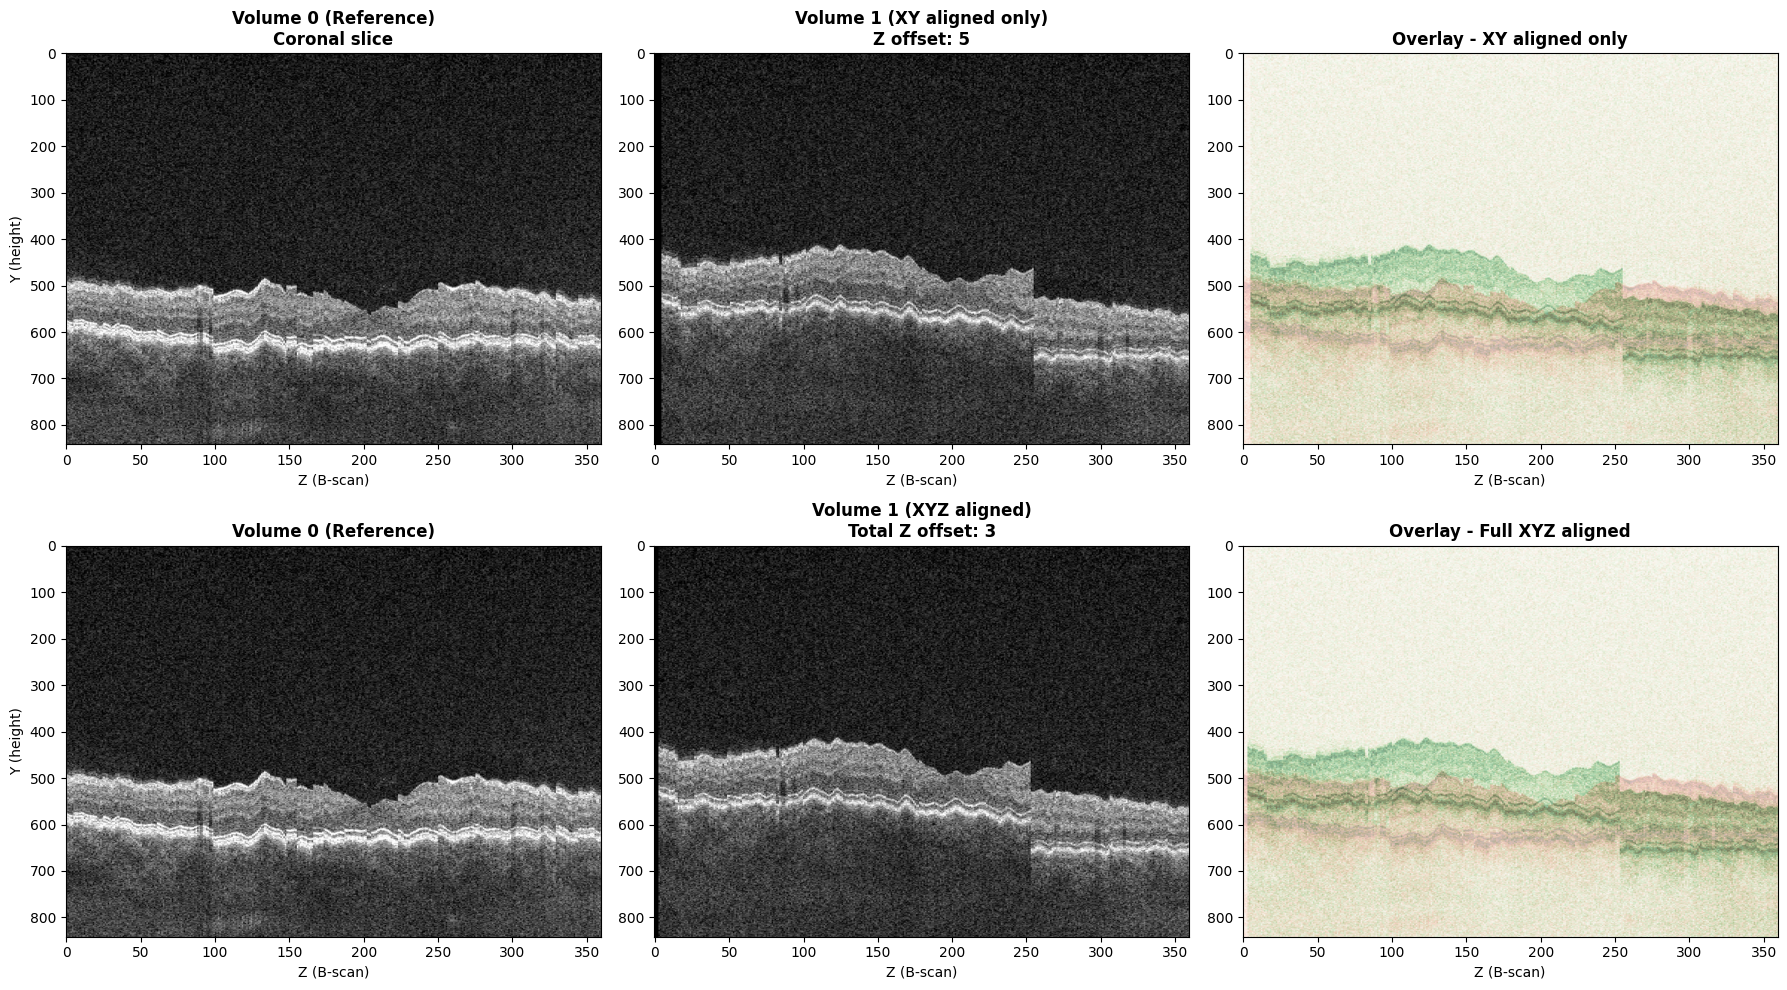


💡 Look for improved alignment in the coronal overlay (Red + Green)


In [6]:
# Apply full Z translation (XY + additional)
total_dz = offset_z_xy + dz_additional

volume_1_xyz_aligned = ndimage.shift(
    volume_1,
    shift=(0, offset_x_xy, total_dz),
    order=1,
    mode='constant',
    cval=0
)

# Visualize coronal slices before/after
mid_x = volume_0.shape[1] // 2

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Before Z alignment (only XY aligned)
axes[0, 0].imshow(volume_0[:, mid_x, :], cmap='gray', aspect='auto')
axes[0, 0].set_title('Volume 0 (Reference)\nCoronal slice', fontweight='bold')
axes[0, 0].set_ylabel('Y (height)')
axes[0, 0].set_xlabel('Z (B-scan)')

axes[0, 1].imshow(volume_1_xy_aligned[:, mid_x, :], cmap='gray', aspect='auto')
axes[0, 1].set_title(f'Volume 1 (XY aligned only)\nZ offset: {offset_z_xy}', fontweight='bold')
axes[0, 1].set_xlabel('Z (B-scan)')

axes[0, 2].imshow(volume_0[:, mid_x, :], cmap='Reds', alpha=0.5, aspect='auto')
axes[0, 2].imshow(volume_1_xy_aligned[:, mid_x, :], cmap='Greens', alpha=0.5, aspect='auto')
axes[0, 2].set_title('Overlay - XY aligned only', fontweight='bold')
axes[0, 2].set_xlabel('Z (B-scan)')

# Row 2: After full XYZ alignment
axes[1, 0].imshow(volume_0[:, mid_x, :], cmap='gray', aspect='auto')
axes[1, 0].set_title('Volume 0 (Reference)', fontweight='bold')
axes[1, 0].set_ylabel('Y (height)')
axes[1, 0].set_xlabel('Z (B-scan)')

axes[1, 1].imshow(volume_1_xyz_aligned[:, mid_x, :], cmap='gray', aspect='auto')
axes[1, 1].set_title(f'Volume 1 (XYZ aligned)\nTotal Z offset: {total_dz}', fontweight='bold')
axes[1, 1].set_xlabel('Z (B-scan)')

axes[1, 2].imshow(volume_0[:, mid_x, :], cmap='Reds', alpha=0.5, aspect='auto')
axes[1, 2].imshow(volume_1_xyz_aligned[:, mid_x, :], cmap='Greens', alpha=0.5, aspect='auto')
axes[1, 2].set_title('Overlay - Full XYZ aligned', fontweight='bold')
axes[1, 2].set_xlabel('Z (B-scan)')

plt.tight_layout()
plt.show()

print("\n💡 Look for improved alignment in the coronal overlay (Red + Green)")

## Step 6: Calculate Quality Metrics

In [7]:
# Calculate differences
diff_xy_only = np.abs(volume_0.astype(float) - volume_1_xy_aligned.astype(float))
diff_xyz = np.abs(volume_0.astype(float) - volume_1_xyz_aligned.astype(float))

improvement = 100 * (1 - diff_xyz.mean() / diff_xy_only.mean())

print("📊 Z-Axis Alignment Quality Metrics:")
print(f"  Mean difference (XY only): {diff_xy_only.mean():.2f}")
print(f"  Mean difference (XYZ):     {diff_xyz.mean():.2f}")
print(f"  Additional improvement:    {improvement:.1f}%")
print(f"\n  Final Z-axis offset:       {total_dz} B-scans")
print(f"    - From XY registration:  {offset_z_xy} B-scans")
print(f"    - Additional from Z-reg: {dz_additional} B-scans")

if improvement > 0:
    print(f"\n✅ Z-axis alignment successful! Improved by {improvement:.1f}%")
else:
    print(f"\n⚠️  Z-axis alignment may not be needed (offset likely ~0)")

📊 Z-Axis Alignment Quality Metrics:
  Mean difference (XY only): 42.58
  Mean difference (XYZ):     42.52
  Additional improvement:    0.1%

  Final Z-axis offset:       3 B-scans
    - From XY registration:  5 B-scans
    - Additional from Z-reg: -2 B-scans

✅ Z-axis alignment successful! Improved by 0.1%


## Step 7: Save Complete XYZ Registration Parameters

In [8]:
# Compile complete 3D transformation (XYZ, but Y will be added in next phase)
registration_xyz = {
    'translation_x': int(offset_x_xy),
    'translation_z': int(total_dz),
    'translation_y': 0,  # Will be determined in Phase 5 (depth alignment)
    
    # Breakdown
    'xy_phase': {
        'method': xy_params['method'],
        'offset_x': int(offset_x_xy),
        'offset_z': int(offset_z_xy),
        'confidence': float(xy_params['confidence'])
    },
    'z_phase': {
        'method': 'phase_correlation_coronal',
        'additional_offset_z': int(dz_additional),
        'total_offset_z': int(total_dz),
        'confidence': float(z_confidence)
    },
    
    # Quality
    'mean_diff_xy_only': float(diff_xy_only.mean()),
    'mean_diff_xyz': float(diff_xyz.mean()),
    'z_improvement_percent': float(improvement)
}

# Save
np.save(data_dir / 'xyz_registration_params.npy', registration_xyz)

print("✓ Saved complete XYZ registration parameters:")
print(f"  - xyz_registration_params.npy")

print("\n✓ Phase 4 Z-axis registration complete!")
print("\nNext step:")
print("  Phase 5: Y-axis (depth) alignment using retinal surface correlation")

print(f"\n\n{'='*70}")
print("SUMMARY - XYZ REGISTRATION")
print(f"{'='*70}")
print(f"X translation (lateral):  {offset_x_xy} pixels")
print(f"Y translation (depth):    TBD (Phase 5)")
print(f"Z translation (B-scans):  {total_dz} B-scans")
print(f"\nZ-axis confidence: {z_confidence:.2f}")
print(f"Z-axis improvement: {improvement:.1f}%")
print(f"{'='*70}")

✓ Saved complete XYZ registration parameters:
  - xyz_registration_params.npy

✓ Phase 4 Z-axis registration complete!

Next step:
  Phase 5: Y-axis (depth) alignment using retinal surface correlation


SUMMARY - XYZ REGISTRATION
X translation (lateral):  -412 pixels
Y translation (depth):    TBD (Phase 5)
Z translation (B-scans):  3 B-scans

Z-axis confidence: 2.55
Z-axis improvement: 0.1%
